In [1]:
import sys
sys.path.append('../modules')

from model import Resnet, Bottleneck
from utils import TinyImageNetDataset, get_preds, extract_CCI, diagonal_order
from cam import get_cam
from simba import SimBA

import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import random
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt

# Extract Correctly Classified Instances

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = TinyImageNetDataset('./data/tiny_imagenet/tiny-imagenet-200', mode = 'val', transform=transform)

Preloading val data...:   0%|          | 0/10000 [00:00<?, ?it/s]

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

model_save_path = './model'
model_list = sorted([x for x in Path(model_save_path).glob('*_epoch_*.pt')], key = lambda x : int(x.stem.strip('model_epoch_')))

best_model_path = model_list[81]

net = Resnet(Bottleneck, [3, 4, 6, 3], num_classes=200).to(device)
net = torch.nn.DataParallel(net, device_ids=[3,4,6,7]).to(device)
net.load_state_dict(torch.load(best_model_path)['state'])

net.eval()

DataParallel(
  (module): Resnet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [7]:
dataset_name = 'tiny_imagenet'
num_data = 1000

In [5]:
extract_CCI(net, num_data, dataset_name, dataset)

../modules/utils.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds[idx], _ = get_preds(model, images[idx], dataset_name, batch_size=batch_size)


# Class Actication Map for CCI

In [3]:
CCI_data = torch.load('./data/tiny_imagenet_CCI.pth')
CCI_images, CCI_labels = CCI_data['images'], CCI_data['labels']

In [4]:
features_blobs = []

def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
    
net._modules.get('module').layer4.register_forward_hook(hook_feature)

In [10]:
CCI_CAM = get_cam(net, features_blobs, CCI_images, 'tiny_imagenet')

NameError: name 'features_blobs' is not defined

In [6]:
torch.save({'CAM' : CCI_CAM}, './data/tiny_imagenet_CCI_CAM.pth')

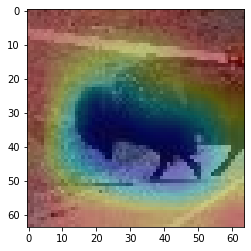

In [26]:
idx = 780

img = np.array(CCI_images[idx].permute(1,2,0))
height, width, _ = img.shape
CAM = cv2.resize(np.uint8(CCI_cam[idx].numpy()), (width, height))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
img_var = np.uint8(255*img)         
result = heatmap * 0.3 + img_var * 0.5
plt.imshow(np.uint8(result))     
plt.show()


# Simple Black-box Attack 

In [4]:
import math

In [5]:
CCI_cam = torch.load('./data/tiny_imagenet_CCI_CAM.pth')['CAM']

In [5]:
image_size = 64
num_data = 1000
batch_size = 25
targeted = False
max_iters = 3*64*64
stride = 0 
epsilon = 0.2
order = 'rand'
log_every = 100
attacker = SimBA(net, 'tiny_imagenet', image_size)

In [7]:
N = int(math.floor(float(num_data) / float(batch_size)))

In [8]:
for i in range(N):
    upper = min((i + 1) * batch_size, num_data)
    images_batch = CCI_images[(i * batch_size):upper]
    labels_batch = CCI_labels[(i * batch_size):upper]
    adv, probs, succs, queries, l2_norms, linf_norms = attacker.simba_batch(
        images_batch, labels_batch, max_iters, stride, epsilon, order=order, targeted=targeted, log_every=log_every)
    
    print(f'{i}th batch attack is finished')
    
    if i == 0:
        all_adv = adv
        all_probs = probs
        all_succs = succs
        all_queries = queries
        all_l2_norms = l2_norms
        all_linf_norms = linf_norms
    else:
        all_adv = torch.cat([all_adv, adv], dim=0)
        all_probs = torch.cat([all_probs, probs], dim=0)
        all_succs = torch.cat([all_succs, succs], dim=0)
        all_queries = torch.cat([all_queries, queries], dim=0)
        all_l2_norms = torch.cat([all_l2_norms, l2_norms], dim=0)
        all_linf_norms = torch.cat([all_linf_norms, linf_norms], dim=0)

Iteration 99 : queries = 103.76000213623047 prob = 0.5604 progress = 64.00
Iteration 199 : queries = 143.8000030517578 prob = 0.4308 progress = 80.00
0th batch attack is finished
Iteration 99 : queries = 109.5199966430664 prob = 0.5811 progress = 56.00
Iteration 199 : queries = 147.24000549316406 prob = 0.4493 progress = 92.00
Iteration 299 : queries = 156.39999389648438 prob = 0.4208 progress = 96.00
1th batch attack is finished
Iteration 99 : queries = 117.23999786376953 prob = 0.5938 progress = 48.00
Iteration 199 : queries = 161.36000061035156 prob = 0.4646 progress = 88.00
Iteration 299 : queries = 182.60000610351562 prob = 0.4549 progress = 88.00
Iteration 399 : queries = 199.47999572753906 prob = 0.4433 progress = 92.00
Iteration 499 : queries = 214.27999877929688 prob = 0.4426 progress = 92.00
Iteration 599 : queries = 229.39999389648438 prob = 0.4403 progress = 92.00
Iteration 699 : queries = 244.47999572753906 prob = 0.4366 progress = 92.00
Iteration 799 : queries = 259.67999

Iteration 10399 : queries = 1037.719970703125 prob = 0.4209 progress = 96.00
Iteration 10499 : queries = 1045.719970703125 prob = 0.4209 progress = 96.00
Iteration 10599 : queries = 1053.719970703125 prob = 0.4209 progress = 96.00
Iteration 10699 : queries = 1061.719970703125 prob = 0.4209 progress = 96.00
Iteration 10799 : queries = 1069.719970703125 prob = 0.4209 progress = 96.00
Iteration 10899 : queries = 1077.719970703125 prob = 0.4209 progress = 96.00
Iteration 10999 : queries = 1085.719970703125 prob = 0.4209 progress = 96.00
Iteration 11099 : queries = 1093.719970703125 prob = 0.4209 progress = 96.00
Iteration 11199 : queries = 1101.719970703125 prob = 0.4209 progress = 96.00
Iteration 11299 : queries = 1109.719970703125 prob = 0.4209 progress = 96.00
Iteration 11399 : queries = 1117.719970703125 prob = 0.4209 progress = 96.00
Iteration 11499 : queries = 1125.719970703125 prob = 0.4209 progress = 96.00
Iteration 11599 : queries = 1133.719970703125 prob = 0.4209 progress = 96.00

Iteration 8899 : queries = 1557.199951171875 prob = 0.4171 progress = 92.00
Iteration 8999 : queries = 1573.199951171875 prob = 0.4171 progress = 92.00
Iteration 9099 : queries = 1589.199951171875 prob = 0.4171 progress = 92.00
Iteration 9199 : queries = 1605.199951171875 prob = 0.4171 progress = 92.00
Iteration 9299 : queries = 1621.199951171875 prob = 0.4171 progress = 92.00
Iteration 9399 : queries = 1637.199951171875 prob = 0.4171 progress = 92.00
Iteration 9499 : queries = 1653.199951171875 prob = 0.4171 progress = 92.00
Iteration 9599 : queries = 1669.199951171875 prob = 0.4171 progress = 92.00
Iteration 9699 : queries = 1685.199951171875 prob = 0.4171 progress = 92.00
Iteration 9799 : queries = 1701.199951171875 prob = 0.4171 progress = 92.00
Iteration 9899 : queries = 1717.199951171875 prob = 0.4171 progress = 92.00
Iteration 9999 : queries = 1733.199951171875 prob = 0.4171 progress = 92.00
Iteration 10099 : queries = 1749.199951171875 prob = 0.4171 progress = 92.00
Iteration 1

Iteration 1199 : queries = 244.75999450683594 prob = 0.4195 progress = 96.00
Iteration 1299 : queries = 252.75999450683594 prob = 0.4195 progress = 96.00
Iteration 1399 : queries = 260.760009765625 prob = 0.4195 progress = 96.00
Iteration 1499 : queries = 268.760009765625 prob = 0.4195 progress = 96.00
Iteration 1599 : queries = 276.760009765625 prob = 0.4195 progress = 96.00
Iteration 1699 : queries = 284.760009765625 prob = 0.4195 progress = 96.00
Iteration 1799 : queries = 292.760009765625 prob = 0.4195 progress = 96.00
Iteration 1899 : queries = 300.760009765625 prob = 0.4195 progress = 96.00
Iteration 1999 : queries = 308.760009765625 prob = 0.4195 progress = 96.00
Iteration 2099 : queries = 316.760009765625 prob = 0.4195 progress = 96.00
Iteration 2199 : queries = 324.760009765625 prob = 0.4195 progress = 96.00
Iteration 2299 : queries = 332.760009765625 prob = 0.4195 progress = 96.00
Iteration 2399 : queries = 340.760009765625 prob = 0.4195 progress = 96.00
Iteration 2499 : quer

Iteration 12099 : queries = 1116.760009765625 prob = 0.4195 progress = 96.00
Iteration 12199 : queries = 1124.760009765625 prob = 0.4195 progress = 96.00
Iteration 12287 : queries = 1131.800048828125 prob = 0.4195 progress = 96.00
19th batch attack is finished
Iteration 99 : queries = 85.91999816894531 prob = 0.4655 progress = 80.00
Iteration 199 : queries = 101.95999908447266 prob = 0.4127 progress = 96.00
Iteration 299 : queries = 108.04000091552734 prob = 0.4042 progress = 96.00
20th batch attack is finished
Iteration 99 : queries = 111.87999725341797 prob = 0.6279 progress = 44.00
Iteration 199 : queries = 160.36000061035156 prob = 0.4700 progress = 84.00
Iteration 299 : queries = 178.0 prob = 0.4432 progress = 92.00
Iteration 399 : queries = 188.8800048828125 prob = 0.4172 progress = 96.00
21th batch attack is finished
Iteration 99 : queries = 114.36000061035156 prob = 0.5739 progress = 68.00
Iteration 199 : queries = 153.44000244140625 prob = 0.4771 progress = 88.00
Iteration 299

Iteration 8799 : queries = 1039.719970703125 prob = 0.4294 progress = 96.00
Iteration 8899 : queries = 1047.719970703125 prob = 0.4294 progress = 96.00
Iteration 8999 : queries = 1055.719970703125 prob = 0.4294 progress = 96.00
Iteration 9099 : queries = 1063.719970703125 prob = 0.4294 progress = 96.00
Iteration 9199 : queries = 1071.719970703125 prob = 0.4294 progress = 96.00
Iteration 9299 : queries = 1079.719970703125 prob = 0.4294 progress = 96.00
Iteration 9399 : queries = 1087.719970703125 prob = 0.4294 progress = 96.00
Iteration 9499 : queries = 1095.719970703125 prob = 0.4294 progress = 96.00
Iteration 9599 : queries = 1103.719970703125 prob = 0.4294 progress = 96.00
Iteration 9699 : queries = 1111.719970703125 prob = 0.4294 progress = 96.00
Iteration 9799 : queries = 1119.719970703125 prob = 0.4294 progress = 96.00
Iteration 9899 : queries = 1127.719970703125 prob = 0.4294 progress = 96.00
Iteration 9999 : queries = 1135.719970703125 prob = 0.4294 progress = 96.00
Iteration 10

Iteration 6499 : queries = 655.9199829101562 prob = 0.4099 progress = 96.00
Iteration 6599 : queries = 663.9199829101562 prob = 0.4099 progress = 96.00
Iteration 6699 : queries = 671.9199829101562 prob = 0.4099 progress = 96.00
Iteration 6799 : queries = 679.9199829101562 prob = 0.4099 progress = 96.00
Iteration 6899 : queries = 687.9199829101562 prob = 0.4099 progress = 96.00
Iteration 6999 : queries = 695.9199829101562 prob = 0.4099 progress = 96.00
Iteration 7099 : queries = 703.9199829101562 prob = 0.4099 progress = 96.00
Iteration 7199 : queries = 711.9199829101562 prob = 0.4099 progress = 96.00
Iteration 7299 : queries = 719.9199829101562 prob = 0.4099 progress = 96.00
Iteration 7399 : queries = 727.9199829101562 prob = 0.4099 progress = 96.00
Iteration 7499 : queries = 735.9199829101562 prob = 0.4099 progress = 96.00
Iteration 7599 : queries = 743.9199829101562 prob = 0.4099 progress = 96.00
Iteration 7699 : queries = 751.9199829101562 prob = 0.4099 progress = 96.00
Iteration 77

Iteration 2199 : queries = 280.8800048828125 prob = 0.4250 progress = 96.00
Iteration 2299 : queries = 288.8800048828125 prob = 0.4250 progress = 96.00
Iteration 2399 : queries = 296.8800048828125 prob = 0.4250 progress = 96.00
Iteration 2499 : queries = 304.8800048828125 prob = 0.4250 progress = 96.00
Iteration 2599 : queries = 312.8800048828125 prob = 0.4250 progress = 96.00
Iteration 2699 : queries = 320.8800048828125 prob = 0.4250 progress = 96.00
Iteration 2799 : queries = 328.8800048828125 prob = 0.4250 progress = 96.00
Iteration 2899 : queries = 336.8800048828125 prob = 0.4250 progress = 96.00
Iteration 2999 : queries = 344.8800048828125 prob = 0.4250 progress = 96.00
Iteration 3099 : queries = 352.8800048828125 prob = 0.4250 progress = 96.00
Iteration 3199 : queries = 360.8800048828125 prob = 0.4250 progress = 96.00
Iteration 3299 : queries = 368.8800048828125 prob = 0.4250 progress = 96.00
Iteration 3399 : queries = 376.8800048828125 prob = 0.4250 progress = 96.00
Iteration 34

Iteration 599 : queries = 193.36000061035156 prob = 0.4108 progress = 96.00
32th batch attack is finished
Iteration 99 : queries = 112.87999725341797 prob = 0.6010 progress = 48.00
Iteration 199 : queries = 166.44000244140625 prob = 0.4557 progress = 80.00
Iteration 299 : queries = 181.47999572753906 prob = 0.4127 progress = 96.00
33th batch attack is finished
Iteration 99 : queries = 92.87999725341797 prob = 0.4792 progress = 68.00
Iteration 199 : queries = 118.04000091552734 prob = 0.3972 progress = 96.00
34th batch attack is finished
Iteration 99 : queries = 96.5199966430664 prob = 0.5755 progress = 56.00
Iteration 199 : queries = 147.39999389648438 prob = 0.4802 progress = 76.00
Iteration 299 : queries = 175.52000427246094 prob = 0.4000 progress = 92.00
Iteration 399 : queries = 182.0800018310547 prob = 0.3994 progress = 96.00
Iteration 499 : queries = 188.47999572753906 prob = 0.3954 progress = 96.00
Iteration 599 : queries = 195.1999969482422 prob = 0.3848 progress = 96.00
35th b

Iteration 9399 : queries = 874.239990234375 prob = 0.4231 progress = 96.00
Iteration 9499 : queries = 882.239990234375 prob = 0.4231 progress = 96.00
Iteration 9599 : queries = 890.239990234375 prob = 0.4231 progress = 96.00
Iteration 9699 : queries = 898.239990234375 prob = 0.4231 progress = 96.00
Iteration 9799 : queries = 906.239990234375 prob = 0.4231 progress = 96.00
Iteration 9899 : queries = 914.239990234375 prob = 0.4231 progress = 96.00
Iteration 9999 : queries = 922.239990234375 prob = 0.4231 progress = 96.00
Iteration 10099 : queries = 930.239990234375 prob = 0.4231 progress = 96.00
Iteration 10199 : queries = 938.239990234375 prob = 0.4231 progress = 96.00
Iteration 10299 : queries = 946.239990234375 prob = 0.4231 progress = 96.00
Iteration 10399 : queries = 954.239990234375 prob = 0.4231 progress = 96.00
Iteration 10499 : queries = 962.239990234375 prob = 0.4231 progress = 96.00
Iteration 10599 : queries = 970.239990234375 prob = 0.4231 progress = 96.00
Iteration 10699 : q

Iteration 7499 : queries = 784.4400024414062 prob = 0.4352 progress = 96.00
Iteration 7599 : queries = 792.4400024414062 prob = 0.4352 progress = 96.00
Iteration 7699 : queries = 800.4400024414062 prob = 0.4352 progress = 96.00
Iteration 7799 : queries = 808.4400024414062 prob = 0.4352 progress = 96.00
Iteration 7899 : queries = 816.4400024414062 prob = 0.4352 progress = 96.00
Iteration 7999 : queries = 824.4400024414062 prob = 0.4352 progress = 96.00
Iteration 8099 : queries = 832.4400024414062 prob = 0.4352 progress = 96.00
Iteration 8199 : queries = 840.4400024414062 prob = 0.4352 progress = 96.00
Iteration 8299 : queries = 848.4400024414062 prob = 0.4352 progress = 96.00
Iteration 8399 : queries = 856.4400024414062 prob = 0.4352 progress = 96.00
Iteration 8499 : queries = 864.4400024414062 prob = 0.4352 progress = 96.00
Iteration 8599 : queries = 872.4400024414062 prob = 0.4352 progress = 96.00
Iteration 8699 : queries = 880.4400024414062 prob = 0.4352 progress = 96.00
Iteration 87

In [9]:
save_path = './data/tiny_imagenet_SimBA_rand.pth'

torch.save({'adv': all_adv, 'probs': all_probs, 'succs': all_succs, 'queries': all_queries,'l2_norms': all_l2_norms, 'linf_norms': all_linf_norms}, save_path)

In [6]:
image_size = 64
num_data = 1000
batch_size = 25
targeted = False
max_iters = 3*64*64
stride = 0 
epsilon = 0.2
order = 'cam'
log_every = 100
attacker = SimBA(net, 'tiny_imagenet', image_size)

N = int(math.floor(float(num_data) / float(batch_size)))

In [7]:
for i in range(N):
    upper = min((i + 1) * batch_size, num_data)
    images_batch = CCI_images[(i * batch_size):upper]
    labels_batch = CCI_labels[(i * batch_size):upper]
    cam_batch = CCI_cam[(i * batch_size):upper]
    adv, probs, succs, queries, l2_norms, linf_norms = attacker.simba_batch(
        images_batch, labels_batch, max_iters, stride, epsilon, order=order, targeted=targeted, log_every=log_every, cam_batch=cam_batch)

    print(f'{i}th batch attack is finished')
    
    if i == 0:
        all_adv = adv
        all_probs = probs
        all_succs = succs
        all_queries = queries
        all_l2_norms = l2_norms
        all_linf_norms = linf_norms
    else:
        all_adv = torch.cat([all_adv, adv], dim=0)
        all_probs = torch.cat([all_probs, probs], dim=0)
        all_succs = torch.cat([all_succs, succs], dim=0)
        all_queries = torch.cat([all_queries, queries], dim=0)
        all_l2_norms = torch.cat([all_l2_norms, l2_norms], dim=0)
        all_linf_norms = torch.cat([all_linf_norms, linf_norms], dim=0)

Iteration 99 : queries = 122.31999969482422 prob = 0.6060 progress = 48.00
Iteration 199 : queries = 194.9199981689453 prob = 0.5022 progress = 68.00
Iteration 299 : queries = 235.16000366210938 prob = 0.4345 progress = 80.00
Iteration 399 : queries = 260.6400146484375 prob = 0.3983 progress = 92.00
Iteration 499 : queries = 268.55999755859375 prob = 0.3864 progress = 96.00
0th batch attack is finished
Iteration 99 : queries = 120.44000244140625 prob = 0.6389 progress = 52.00
Iteration 199 : queries = 200.36000061035156 prob = 0.5796 progress = 60.00
Iteration 299 : queries = 268.3599853515625 prob = 0.5192 progress = 64.00
Iteration 399 : queries = 311.67999267578125 prob = 0.4675 progress = 84.00
Iteration 499 : queries = 334.8800048828125 prob = 0.4322 progress = 92.00
1th batch attack is finished
Iteration 99 : queries = 128.0 prob = 0.6219 progress = 52.00
Iteration 199 : queries = 202.16000366210938 prob = 0.5731 progress = 64.00
Iteration 299 : queries = 263.8399963378906 prob =

Iteration 9999 : queries = 1218.239990234375 prob = 0.4193 progress = 96.00
Iteration 10099 : queries = 1226.239990234375 prob = 0.4193 progress = 96.00
Iteration 10199 : queries = 1234.239990234375 prob = 0.4193 progress = 96.00
Iteration 10299 : queries = 1242.239990234375 prob = 0.4193 progress = 96.00
Iteration 10399 : queries = 1250.239990234375 prob = 0.4193 progress = 96.00
Iteration 10499 : queries = 1258.239990234375 prob = 0.4193 progress = 96.00
Iteration 10599 : queries = 1266.239990234375 prob = 0.4193 progress = 96.00
Iteration 10699 : queries = 1274.239990234375 prob = 0.4193 progress = 96.00
Iteration 10799 : queries = 1282.239990234375 prob = 0.4193 progress = 96.00
Iteration 10899 : queries = 1290.239990234375 prob = 0.4193 progress = 96.00
Iteration 10999 : queries = 1298.239990234375 prob = 0.4193 progress = 96.00
Iteration 11099 : queries = 1306.239990234375 prob = 0.4193 progress = 96.00
Iteration 11199 : queries = 1314.239990234375 prob = 0.4193 progress = 96.00


Iteration 8399 : queries = 1614.0799560546875 prob = 0.4186 progress = 92.00
Iteration 8499 : queries = 1630.0799560546875 prob = 0.4186 progress = 92.00
Iteration 8599 : queries = 1646.0799560546875 prob = 0.4186 progress = 92.00
Iteration 8699 : queries = 1662.0799560546875 prob = 0.4186 progress = 92.00
Iteration 8799 : queries = 1678.0799560546875 prob = 0.4186 progress = 92.00
Iteration 8899 : queries = 1694.0799560546875 prob = 0.4186 progress = 92.00
Iteration 8999 : queries = 1710.0799560546875 prob = 0.4186 progress = 92.00
Iteration 9099 : queries = 1726.0799560546875 prob = 0.4186 progress = 92.00
Iteration 9199 : queries = 1742.0799560546875 prob = 0.4186 progress = 92.00
Iteration 9299 : queries = 1758.0799560546875 prob = 0.4186 progress = 92.00
Iteration 9399 : queries = 1774.0799560546875 prob = 0.4186 progress = 92.00
Iteration 9499 : queries = 1790.0799560546875 prob = 0.4186 progress = 92.00
Iteration 9599 : queries = 1806.0799560546875 prob = 0.4186 progress = 92.00

Iteration 399 : queries = 289.20001220703125 prob = 0.4694 progress = 84.00
Iteration 499 : queries = 318.9599914550781 prob = 0.4533 progress = 84.00
Iteration 599 : queries = 348.7200012207031 prob = 0.4285 progress = 88.00
Iteration 699 : queries = 360.9599914550781 prob = 0.4202 progress = 96.00
Iteration 799 : queries = 367.9599914550781 prob = 0.4194 progress = 96.00
Iteration 899 : queries = 375.3599853515625 prob = 0.4179 progress = 96.00
Iteration 999 : queries = 382.7200012207031 prob = 0.4145 progress = 96.00
Iteration 1099 : queries = 390.1199951171875 prob = 0.4054 progress = 96.00
12th batch attack is finished
Iteration 99 : queries = 128.0800018310547 prob = 0.5972 progress = 40.00
Iteration 199 : queries = 207.60000610351562 prob = 0.4726 progress = 64.00
Iteration 299 : queries = 235.83999633789062 prob = 0.4272 progress = 92.00
Iteration 399 : queries = 249.8800048828125 prob = 0.4262 progress = 92.00
Iteration 499 : queries = 264.0 prob = 0.4227 progress = 92.00
Iter

Iteration 6399 : queries = 745.8800048828125 prob = 0.4174 progress = 96.00
Iteration 6499 : queries = 753.8800048828125 prob = 0.4174 progress = 96.00
Iteration 6599 : queries = 761.8800048828125 prob = 0.4174 progress = 96.00
Iteration 6699 : queries = 769.8800048828125 prob = 0.4174 progress = 96.00
Iteration 6799 : queries = 777.8800048828125 prob = 0.4174 progress = 96.00
Iteration 6899 : queries = 785.8800048828125 prob = 0.4174 progress = 96.00
Iteration 6999 : queries = 793.8800048828125 prob = 0.4174 progress = 96.00
Iteration 7099 : queries = 801.8800048828125 prob = 0.4174 progress = 96.00
Iteration 7199 : queries = 809.8800048828125 prob = 0.4174 progress = 96.00
Iteration 7299 : queries = 817.8800048828125 prob = 0.4174 progress = 96.00
Iteration 7399 : queries = 825.8800048828125 prob = 0.4174 progress = 96.00
Iteration 7499 : queries = 833.8800048828125 prob = 0.4174 progress = 96.00
Iteration 7599 : queries = 841.8800048828125 prob = 0.4174 progress = 96.00
Iteration 76

Iteration 499 : queries = 259.3999938964844 prob = 0.4535 progress = 88.00
Iteration 599 : queries = 277.44000244140625 prob = 0.4444 progress = 92.00
Iteration 699 : queries = 292.4800109863281 prob = 0.4386 progress = 92.00
Iteration 799 : queries = 306.3999938964844 prob = 0.4261 progress = 96.00
Iteration 899 : queries = 314.3999938964844 prob = 0.4261 progress = 96.00
Iteration 999 : queries = 322.3999938964844 prob = 0.4261 progress = 96.00
Iteration 1099 : queries = 330.3999938964844 prob = 0.4261 progress = 96.00
Iteration 1199 : queries = 338.3999938964844 prob = 0.4261 progress = 96.00
Iteration 1299 : queries = 346.3999938964844 prob = 0.4261 progress = 96.00
Iteration 1399 : queries = 354.3999938964844 prob = 0.4261 progress = 96.00
Iteration 1499 : queries = 362.3999938964844 prob = 0.4261 progress = 96.00
Iteration 1599 : queries = 370.3999938964844 prob = 0.4261 progress = 96.00
Iteration 1699 : queries = 378.3999938964844 prob = 0.4261 progress = 96.00
Iteration 1799 : 

Iteration 11299 : queries = 1146.4000244140625 prob = 0.4261 progress = 96.00
Iteration 11399 : queries = 1154.4000244140625 prob = 0.4261 progress = 96.00
Iteration 11499 : queries = 1162.4000244140625 prob = 0.4261 progress = 96.00
Iteration 11599 : queries = 1170.4000244140625 prob = 0.4261 progress = 96.00
Iteration 11699 : queries = 1178.4000244140625 prob = 0.4261 progress = 96.00
Iteration 11799 : queries = 1186.4000244140625 prob = 0.4261 progress = 96.00
Iteration 11899 : queries = 1194.4000244140625 prob = 0.4261 progress = 96.00
Iteration 11999 : queries = 1202.4000244140625 prob = 0.4261 progress = 96.00
Iteration 12099 : queries = 1210.4000244140625 prob = 0.4261 progress = 96.00
Iteration 12199 : queries = 1218.4000244140625 prob = 0.4261 progress = 96.00
Iteration 12287 : queries = 1225.43994140625 prob = 0.4261 progress = 96.00
24th batch attack is finished
Iteration 99 : queries = 122.55999755859375 prob = 0.5820 progress = 60.00
Iteration 199 : queries = 174.440002441

Iteration 8299 : queries = 935.1199951171875 prob = 0.4097 progress = 96.00
Iteration 8399 : queries = 943.1199951171875 prob = 0.4097 progress = 96.00
Iteration 8499 : queries = 951.1199951171875 prob = 0.4097 progress = 96.00
Iteration 8599 : queries = 959.1199951171875 prob = 0.4097 progress = 96.00
Iteration 8699 : queries = 967.1199951171875 prob = 0.4097 progress = 96.00
Iteration 8799 : queries = 975.1199951171875 prob = 0.4097 progress = 96.00
Iteration 8899 : queries = 983.1199951171875 prob = 0.4097 progress = 96.00
Iteration 8999 : queries = 991.1199951171875 prob = 0.4097 progress = 96.00
Iteration 9099 : queries = 999.1199951171875 prob = 0.4097 progress = 96.00
Iteration 9199 : queries = 1007.1199951171875 prob = 0.4097 progress = 96.00
Iteration 9299 : queries = 1015.1199951171875 prob = 0.4097 progress = 96.00
Iteration 9399 : queries = 1023.1199951171875 prob = 0.4097 progress = 96.00
Iteration 9499 : queries = 1031.1199951171875 prob = 0.4097 progress = 96.00
Iteratio

Iteration 3399 : queries = 477.1600036621094 prob = 0.4329 progress = 96.00
Iteration 3499 : queries = 485.1600036621094 prob = 0.4329 progress = 96.00
Iteration 3599 : queries = 493.1600036621094 prob = 0.4329 progress = 96.00
Iteration 3699 : queries = 501.1600036621094 prob = 0.4329 progress = 96.00
Iteration 3799 : queries = 509.1600036621094 prob = 0.4329 progress = 96.00
Iteration 3899 : queries = 517.1599731445312 prob = 0.4329 progress = 96.00
Iteration 3999 : queries = 525.1599731445312 prob = 0.4329 progress = 96.00
Iteration 4099 : queries = 533.1599731445312 prob = 0.4329 progress = 96.00
Iteration 4199 : queries = 541.1599731445312 prob = 0.4329 progress = 96.00
Iteration 4299 : queries = 549.1599731445312 prob = 0.4329 progress = 96.00
Iteration 4399 : queries = 557.1599731445312 prob = 0.4329 progress = 96.00
Iteration 4499 : queries = 565.1599731445312 prob = 0.4329 progress = 96.00
Iteration 4599 : queries = 573.1599731445312 prob = 0.4329 progress = 96.00
Iteration 46

Iteration 499 : queries = 238.0399932861328 prob = 0.4010 progress = 88.00
Iteration 599 : queries = 255.63999938964844 prob = 0.3823 progress = 96.00
Iteration 699 : queries = 262.9200134277344 prob = 0.3812 progress = 96.00
Iteration 799 : queries = 270.1199951171875 prob = 0.3785 progress = 96.00
Iteration 899 : queries = 277.32000732421875 prob = 0.3713 progress = 96.00
Iteration 999 : queries = 284.6000061035156 prob = 0.3635 progress = 96.00
34th batch attack is finished
Iteration 99 : queries = 122.80000305175781 prob = 0.5949 progress = 44.00
Iteration 199 : queries = 196.1199951171875 prob = 0.5156 progress = 64.00
Iteration 299 : queries = 246.27999877929688 prob = 0.4698 progress = 76.00
Iteration 399 : queries = 285.0799865722656 prob = 0.4382 progress = 84.00
Iteration 499 : queries = 311.4800109863281 prob = 0.4106 progress = 92.00
Iteration 599 : queries = 326.2799987792969 prob = 0.3936 progress = 92.00
Iteration 699 : queries = 336.44000244140625 prob = 0.3734 progress

Iteration 9099 : queries = 972.3200073242188 prob = 0.4185 progress = 96.00
Iteration 9199 : queries = 980.3200073242188 prob = 0.4185 progress = 96.00
Iteration 9299 : queries = 988.3200073242188 prob = 0.4185 progress = 96.00
Iteration 9399 : queries = 996.3200073242188 prob = 0.4185 progress = 96.00
Iteration 9499 : queries = 1004.3200073242188 prob = 0.4185 progress = 96.00
Iteration 9599 : queries = 1012.3200073242188 prob = 0.4185 progress = 96.00
Iteration 9699 : queries = 1020.3200073242188 prob = 0.4185 progress = 96.00
Iteration 9799 : queries = 1028.3199462890625 prob = 0.4185 progress = 96.00
Iteration 9899 : queries = 1036.3199462890625 prob = 0.4185 progress = 96.00
Iteration 9999 : queries = 1044.3199462890625 prob = 0.4185 progress = 96.00
Iteration 10099 : queries = 1052.3199462890625 prob = 0.4185 progress = 96.00
Iteration 10199 : queries = 1060.3199462890625 prob = 0.4185 progress = 96.00
Iteration 10299 : queries = 1068.3199462890625 prob = 0.4185 progress = 96.00


Iteration 8199 : queries = 915.0 prob = 0.4393 progress = 96.00
Iteration 8299 : queries = 923.0 prob = 0.4393 progress = 96.00
Iteration 8399 : queries = 931.0 prob = 0.4393 progress = 96.00
Iteration 8499 : queries = 939.0 prob = 0.4393 progress = 96.00
Iteration 8599 : queries = 947.0 prob = 0.4393 progress = 96.00
Iteration 8699 : queries = 955.0 prob = 0.4393 progress = 96.00
Iteration 8799 : queries = 963.0 prob = 0.4393 progress = 96.00
Iteration 8899 : queries = 971.0 prob = 0.4393 progress = 96.00
Iteration 8999 : queries = 979.0 prob = 0.4393 progress = 96.00
Iteration 9099 : queries = 987.0 prob = 0.4393 progress = 96.00
Iteration 9199 : queries = 995.0 prob = 0.4393 progress = 96.00
Iteration 9299 : queries = 1003.0 prob = 0.4393 progress = 96.00
Iteration 9399 : queries = 1011.0 prob = 0.4393 progress = 96.00
Iteration 9499 : queries = 1019.0 prob = 0.4393 progress = 96.00
Iteration 9599 : queries = 1027.0 prob = 0.4393 progress = 96.00
Iteration 9699 : queries = 1035.0 pr

In [8]:
save_path = './data/tiny_imagenet_SimBA_cam.pth'

torch.save({'adv': all_adv, 'probs': all_probs, 'succs': all_succs, 'queries': all_queries,'l2_norms': all_l2_norms, 'linf_norms': all_linf_norms}, save_path)